<a href="https://colab.research.google.com/github/iamdurgesh/CA-Housing-Analysis/blob/feature/ca_housing_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import sys

assert sys.version_info >= (3, 7)

Getting the Data to predict Median House values in California

In [7]:
# pip install pathlib
# pip3 install scikit-learn
# python --version


In [8]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [9]:
# To save figure images
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [10]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents = True, exist_ok = True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [11]:
housing.head()      #To see the top5 Data_Frames


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
housing.info()    # To see the quick description of the Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [13]:
housing["ocean_proximity"].value_counts()   # To find the total categorical attributes

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [14]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


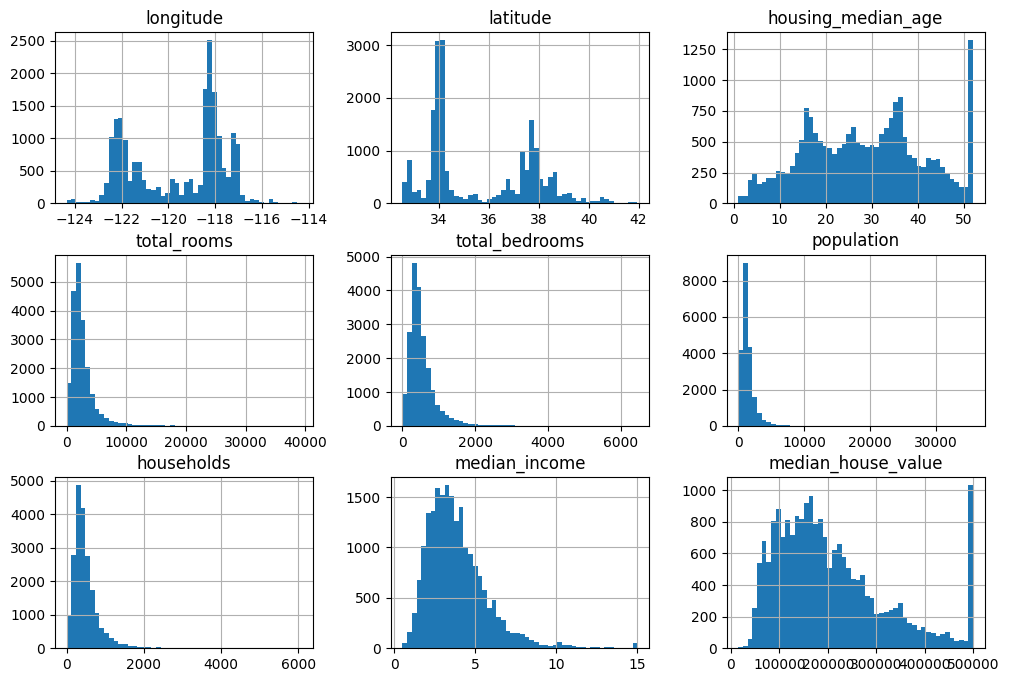

In [15]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12,8))
plt.show()

In [16]:
import numpy as np
def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [17]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)


16512

In [18]:
len(test_set)

4128

From the abve data set generation code, everytime there will be a new test set will be generated which will make all the values available to the algorithm in meantime. To prevent this we use hashof each instance's to identifier, put the instance in testset if the hash is lower than 20% of the max hash value.

In [19]:
from zlib import crc32
def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) <test_ratio * 2 ** 32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_:is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()    # adds an 'index' column
# train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index") # row index as ID
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]   # to build a unique identifier, latitude and longitude are uniques and constant  over time
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")


In [20]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [21]:
# !pip install scikit-learn
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

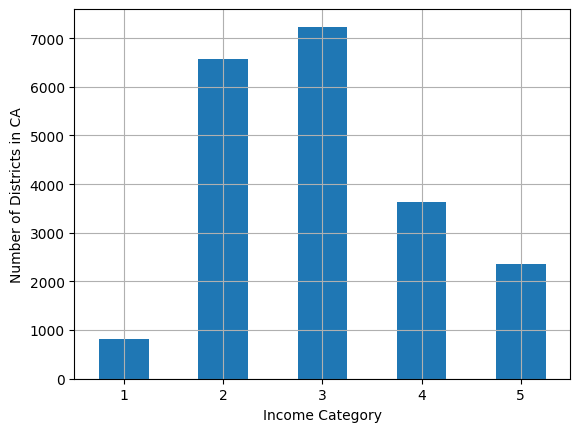

In [22]:
# Sorting the districts based on the housing median income into 5 categories
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts in CA")
plt.show()

In [23]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify = housing["income_cat"], random_state=42)
strat_train_set["income_cat"].value_counts() / len(strat_test_set)



income_cat
3    1.402374
2    1.275436
4    0.705184
5    0.457849
1    0.159157
Name: count, dtype: float64

In [24]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)
# strat_test_set.info()
strat_test_set.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,5
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN,4
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN,3
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN,3
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY,3


In [25]:
for set_ in (strat_train_set, strat_test_set):    # Now to remove the income_cat attribute from the dataset
  set_.drop("income_cat", axis=1, inplace=True)

In [26]:
strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY


In [27]:
housing = strat_train_set.copy()

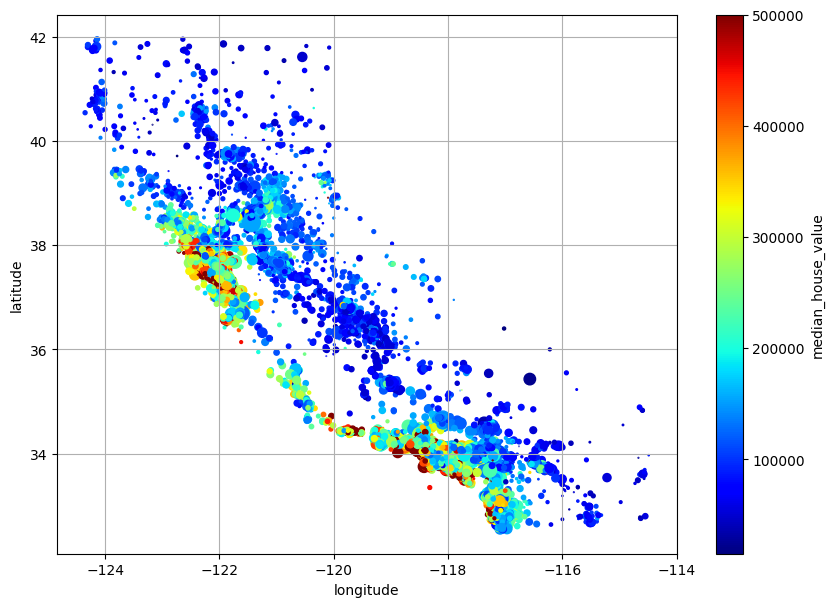

In [28]:
# housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)  #Alpha shows the plot based in the density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100 , c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [29]:
# Correlation coefficient(Pearson's r) using corr() method
# corr_matrix = housing.corr(numeric_only=True)
# corr_matrix["median_house_value"].sort__values(ascending=False)

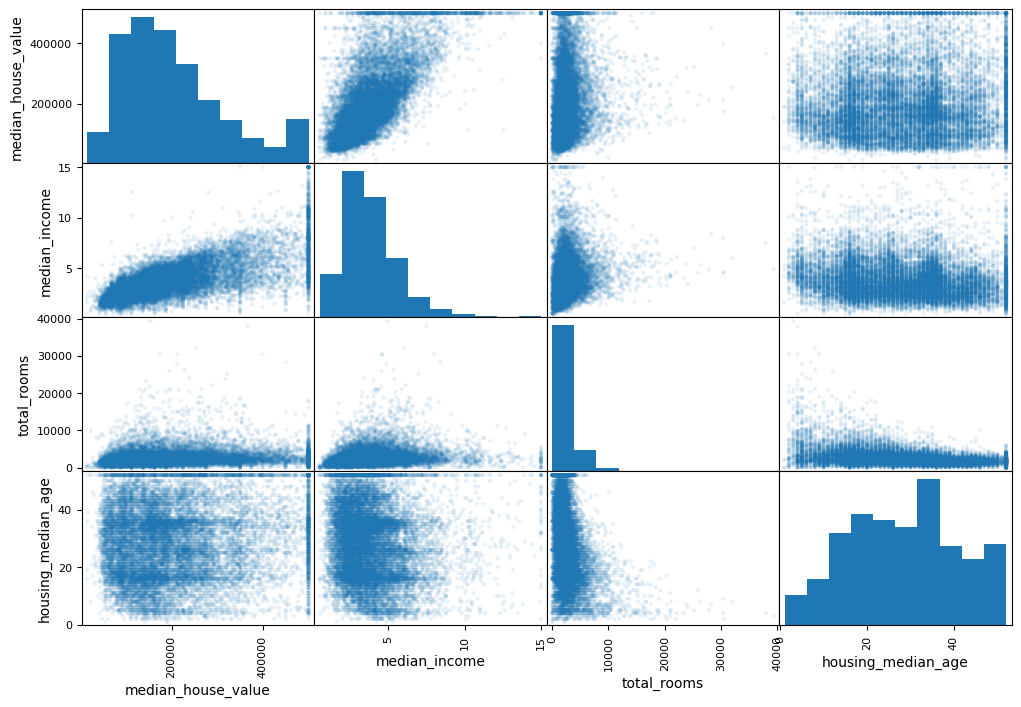

In [30]:
#Another way to find the correlation using the pandas.plotting
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8), alpha=0.1)
plt.show()

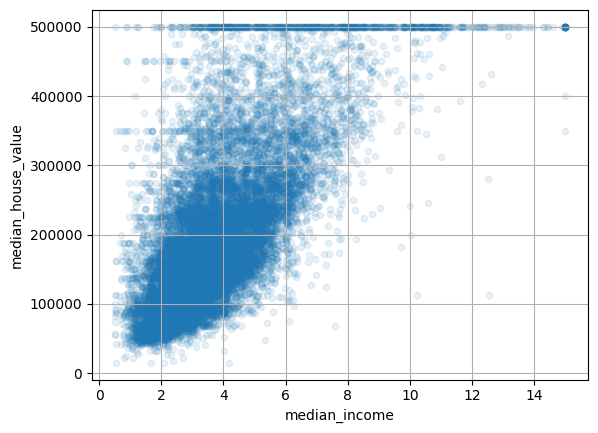

In [31]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", grid=True, alpha=0.1)
plt.show()

In [32]:
# Adding further important attributes for correlation
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [33]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399


In [34]:
# Checking the correlation matrix
# housing_numeric = housing.drop("ocean_proximity", axis=1) #To drop non-numeric values, or ust add numeric_only=True in the .corr(argument)
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [35]:
# Reverting to the clean traing set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [36]:
#----------------------------- Clean The Data---------------------------
# housing.dropna(subset=["total_bedrooms"], inplace=True)  #Method 1
# housing.drop("total_bedrooms", axis=1)    #Method 2
median = housing["total_bedrooms"].median() #Method 3, useful cause, we can use simpleImputer later with this to impute test_set missing values


In [37]:
# Imputing the mising values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])  # Excluding non-numerical attributes "ocean_proximity"

In [38]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [39]:
imputer.statistics_


array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [40]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [41]:
housing_num.head()  # Removed the non-numeric attribute

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [42]:
X = imputer.transform(housing_num)  # Using the Trained imputer to transform the missing values, also check other imputer strategies

In [43]:
# Scikit-Learn transformers output numpy arra even if input is a panda dataFrame, but we can wrap 'X' and recover the dataFrame as
# housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing__num.index)

In [44]:
# Handling Text and Categorical Attributes
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(7)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN


In [45]:
# Converting Text Attributes to numbers and categorizing using OrdinalEncoder class:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
# housing_cat_encoded.head(8) # Won't work as numpy.ndarra has no head attribute
housing_cat_encoded[:15]


array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [4.]])

In [46]:
ordinal_encoder.categories_ # issue is assuming similarities between two near values, and reecting distant values,

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [47]:
# Using one hot encoding such that each category will become its own attribute(one binary attribte per category) or also called dummy attribute
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
# housing_cat_1hot[5] # Output will be a sciPy sparse matrix
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [48]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [49]:
# Alternatively pandas also has One-Hot encoded representation of dummy data with one-binar feature category
df_test = pd.DataFrame({"ocean_proximity":["INLAND", "ISLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY
0,True,False,False
1,False,True,False
2,False,False,True


In [50]:
# But scikit-learn one-hot-encoder remembers the categories it was trained on, therefore
encoded__1hot_df_test= cat_encoder.transform(df_test)
encoded__1hot_df_test.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [51]:
df_test_unknown = pd.DataFrame({"ocean_proximity":["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)   # Also outputs unknown category "<2H OCEAN", But one hot encoder is smarter

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [52]:
cat_encoder.handle_unknown = "ignore" # Unknow categories ignored
a= cat_encoder.transform(df_test_unknown)
a.toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [53]:
# Scikit-learn estimators stores the input feature names as
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [54]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [55]:
# df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
#                          columns=cat_encoder.get_feature_names_out(),
#                          index=df_test_unknown.index)
# df_output

In [56]:
# -----------------------------------Feature SCALING ---------------------------------------------
# Commom Scaling methods are min-max scaling(Normalization), and standardization
#a. using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))  #Default range is 0-1
housing_num_min_max_scaler = min_max_scaler.fit_transform(housing_num)

In [57]:
#b Using Standardization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaler = std_scaler.fit_transform(housing_num)

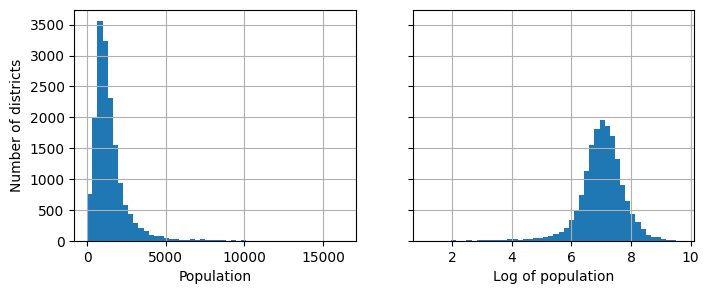

In [58]:
# To plot graphically
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
# save_fig("long_tail_plot")
plt.show()

In [59]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

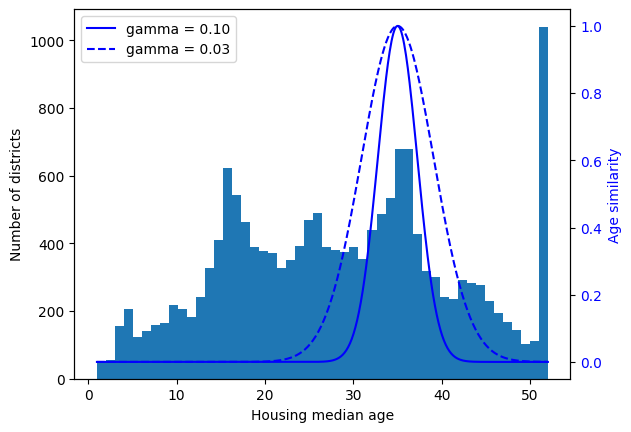

In [60]:
#this cell generates gaussian rbf features similarity b/w housing_median_age and 35

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
# save_fig("age_similarity_plot")
plt.show()

In [61]:
from sklearn.linear_model import LinearRegression
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] # To pretend this is a new data
scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)


In [62]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [63]:
# The above same can be achieved using TransformedTargetRegressor
from sklearn.compose import TransformedTargetRegressor
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [64]:
#----------------------------------CUSTOM Transformers--------------------------------------------
# Creating a log Transformer on population Feature:
from sklearn.preprocessing import FunctionTransformer
log_transformer =  FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [65]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35


array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [66]:
# As there is no inverse function for RBF Kernel
# Ex adding feature to measure geographic similarity b/w each District and San-Francisco:
sf_coords = 37.7749, -112.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [67]:
# Combining features using Custom Transformers
# Ex. Function Transformer, that computes the ratio between 0 and 1
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]]/ X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True):   #no args** or kwargs**!
      self.with_mean = with_mean

  def fit(self, X, y=None): # "y" is reuired even though we don't use it
      X = check_array(X)        # checks that X is an array with finite float values
      self.mean_ = X.mean(axis=0)
      self.scale_= X.std(axis=0)
      self.n_features_in_ = X.shape[1]  # EVERY estimator stores this in fit()
      return self           # always return self

  def transform(self, X):
    check_is_fitted(self)   # looks for learned attribute(with trailing_)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean_
    return X / self.scale_

In [69]:
# Custom Transformer with K-means clustering in fit(), to identify main clusters in the training data
from sklearn.cluster import KMeans
class clusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self         # always returns self

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [70]:
# Now using the K-means cluster Transformer
cluster_simil = clusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [71]:
similarities[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

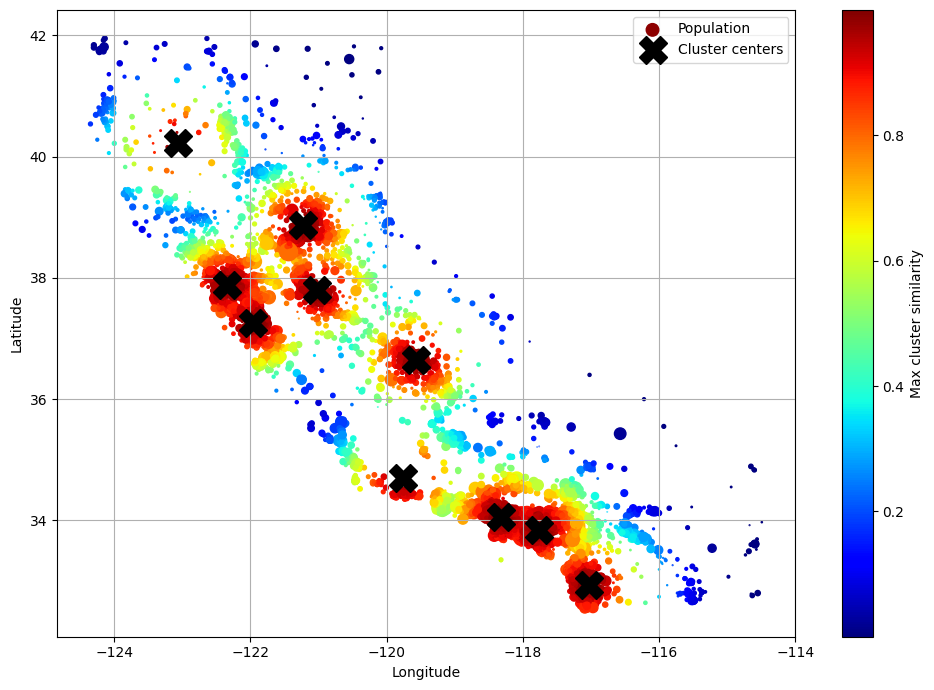

In [75]:
# 10 Cluster centers found by K-means
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()